## Import the dependencies

In [1]:
import keras
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate, AveragePooling2D, Flatten
from keras.models import Model

import cv2
from keras.utils import np_utils
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras.callbacks as callbacks
import math
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score

## create inception module

In [2]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     bias_init, kernel_init,
                     name=None):
    conv_1x1 = Conv2D(filters=filters_1x1, kernel_size=(1, 1),
                      padding='same', activation='relu',
                      bias_initializer=bias_init, kernel_initializer=kernel_init)(x)

    conv_3x3 = Conv2D(filters=filters_3x3_reduce, kernel_size=(1, 1),
                      padding='same', activation='relu',
                      bias_initializer=bias_init, kernel_initializer=kernel_init)(x)
    conv_3x3 = Conv2D(filters=filters_3x3, kernel_size=(3, 3),
                      padding='same', activation='relu',
                      bias_initializer=bias_init, kernel_initializer=kernel_init)(conv_3x3)

    conv_5x5 = Conv2D(filters=filters_5x5_reduce, kernel_size=(1, 1),
                      padding='same', activation='relu',
                      bias_initializer=bias_init, kernel_initializer=kernel_init)(x)
    conv_5x5 = Conv2D(filters=filters_5x5, kernel_size=(5, 5),
                      padding='same', activation='relu',
                      bias_initializer=bias_init, kernel_initializer=kernel_init)(conv_5x5)

    pool_proj = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters=filters_pool_proj, kernel_size=(1, 1),
                       padding='same', activation='relu',
                       bias_initializer=bias_init, kernel_initializer=kernel_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    return output

In [3]:
def get_model():
    kernel_init = keras.initializers.glorot_uniform()
    bias_init = keras.initializers.Constant(value=0.2)
    input_layer = Input(shape=(256, 256, 3))

    x = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),
               padding='same', activation='relu',
               bias_initializer=bias_init, kernel_initializer=kernel_init,
               name='CONV_1')(input_layer)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),
                  name='MaxPool_1')(x)

    x = inception_module(x=x,
                         filters_1x1=8,
                         filters_3x3=12, filters_3x3_reduce=12,
                         filters_5x5=4, filters_5x5_reduce=4,
                         filters_pool_proj=8,
                         bias_init=bias_init, kernel_init=kernel_init,
                         name='INCEPT_1')
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),
                  name='MaxPool_2')(x)

    x = inception_module(x=x,
                         filters_1x1=16,
                         filters_3x3=24, filters_3x3_reduce=24,
                         filters_5x5=8, filters_5x5_reduce=8,
                         filters_pool_proj=16,
                         bias_init=bias_init, kernel_init=kernel_init,
                         name='INCEPT_2')
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),
                  name='MaxPool_3')(x)

    x = inception_module(x=x,
                         filters_1x1=32,
                         filters_3x3=48, filters_3x3_reduce=48,
                         filters_5x5=16, filters_5x5_reduce=16,
                         filters_pool_proj=32,
                         bias_init=bias_init, kernel_init=kernel_init,
                         name='INCEPT_3')
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),
                  name='MaxPool_4')(x)

    x = inception_module(x=x,
                         filters_1x1=64,
                         filters_3x3=96, filters_3x3_reduce=96,
                         filters_5x5=32, filters_5x5_reduce=32,
                         filters_pool_proj=64,
                         bias_init=bias_init, kernel_init=kernel_init,
                         name='INCEPT_4')
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),
                  name='MaxPool_5')(x)

    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(2, 2),
               padding='same', activation='relu',
               bias_initializer=bias_init, kernel_initializer=kernel_init,
               name='CONV_2')(x)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2),
                         name='AvgPool_1')(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu', name='linear')(x)
    x = Dense(2, activation='softmax', name='output')(x)

    model = Model(input_layer, [x], name='StenographyDetector')
    return model

In [4]:
sd_model = get_model()
sd_model.summary()

Model: "StenographyDetector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
CONV_1 (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
MaxPool_1 (MaxPooling2D)        (None, 127, 127, 16) 0           CONV_1[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 12) 204         MaxPool_1[0][0]                  
________________________________________________________________________________

## Prepare the data:

In [5]:
num_classes = 2


def load_data():
    with open('MICC-F2000/ext_classes.txt') as file_with_names:
        list_imgs = file_with_names.readlines()
    file_with_names.close()

    list_img_name_class = []
    for line in list_imgs:
        line = line[:-1]
        list_img_name_class.append((line.split('\t')[0], int(line.split('\t')[1])))

    x_data = []
    y_data = []
    for rec in list_img_name_class:
        x_data.append(cv2.imread('MICC-F2000/extended/' + rec[0]))
        y_data.append(rec[1])

    x_data = np.array(x_data)
    y_data = np_utils.to_categorical(y_data, num_classes)
    return x_data, y_data


xx, yy = load_data()

In [6]:
print(xx.shape)
print(yy)

(10000, 256, 256, 3)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [7]:
# with huge amount of data it doesn't work properly
# xx = xx / 255.0

In [8]:
train_size = 0.9
valid_size = 0.05
test_size = 0.05

x_train, x_test, y_train, y_test = train_test_split(xx, yy, test_size=test_size, random_state=13)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=142)

## MODEL STUDYING

In [9]:
sd_model.compile(loss='categorical_crossentropy',
                 optimizer='adamax',
                 metrics=['accuracy'])

In [10]:
history = sd_model.fit(x_train, y_train, batch_size=50, epochs=40,
                       validation_data=(x_valid, y_valid),
                       verbose=2, shuffle=True)

Epoch 1/40
190/190 - 48s - loss: 1.7589 - accuracy: 0.6348 - val_loss: 0.5728 - val_accuracy: 0.7200
Epoch 2/40
190/190 - 44s - loss: 0.5795 - accuracy: 0.6989 - val_loss: 0.5352 - val_accuracy: 0.7200
Epoch 3/40
190/190 - 45s - loss: 0.5130 - accuracy: 0.7471 - val_loss: 0.4567 - val_accuracy: 0.8160
Epoch 4/40
190/190 - 44s - loss: 0.4422 - accuracy: 0.7957 - val_loss: 0.4089 - val_accuracy: 0.8200
Epoch 5/40
190/190 - 44s - loss: 0.3793 - accuracy: 0.8338 - val_loss: 0.3338 - val_accuracy: 0.8240
Epoch 6/40
190/190 - 44s - loss: 0.3428 - accuracy: 0.8543 - val_loss: 0.3770 - val_accuracy: 0.7960
Epoch 7/40
190/190 - 44s - loss: 0.3130 - accuracy: 0.8749 - val_loss: 0.3409 - val_accuracy: 0.8920
Epoch 8/40
190/190 - 44s - loss: 0.2961 - accuracy: 0.8845 - val_loss: 0.3377 - val_accuracy: 0.8440
Epoch 9/40
190/190 - 44s - loss: 0.2778 - accuracy: 0.8935 - val_loss: 0.2749 - val_accuracy: 0.8960
Epoch 10/40
190/190 - 44s - loss: 0.2774 - accuracy: 0.8952 - val_loss: 0.3129 - val_accura

In [11]:
scores = sd_model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores[1] * 100, scores [0]))

2/2 [==============================] - 3s 1s/step - loss: 0.1028 - accuracy: 0.9720
Test result: 97.200 loss: 0.103


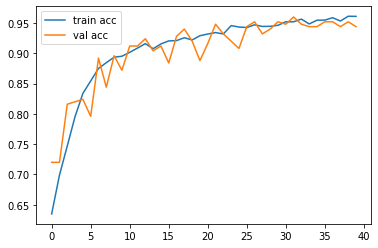

In [12]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

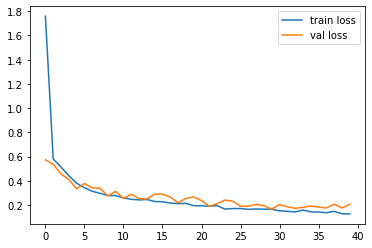

In [13]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [19]:
sd_model.save('model_v1.dat')

INFO:tensorflow:Assets written to: model_v1.dat/assets


In [15]:
y_test_pred = sd_model.predict(x_test)

In [16]:
confusion_matrix = tf.math.confusion_matrix(y_test.argmax(axis=1), y_test_pred.argmax(axis=1))

In [17]:
confusion_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[152,   6],
       [  1,  91]], dtype=int32)>

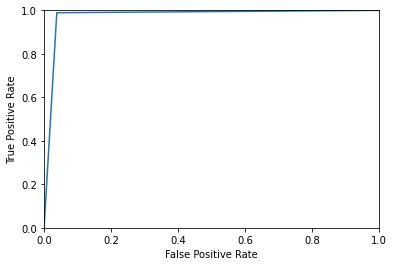

In [18]:
fpr_m, tpr_m, thresholds_m = roc_curve(y_test.argmax(axis=1), y_test_pred.argmax(axis=1))

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr,tpr)
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

plot_roc_curve (fpr_m, tpr_m)